In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import io
import matplotlib.pyplot as plt
import time
import os
import copy
from glob import glob
from tqdm import tqdm
import warnings
import pandas as pd
from sklearn.metrics import f1_score,accuracy_score,recall_score,roc_auc_score,roc_curve,confusion_matrix
warnings.simplefilter('ignore')
import seaborn as sns
import matplotlib.pyplot as plt
from torch.utils.data import Subset

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
print(torch.cuda.get_device_name())

BATCH_SIZE=2
EPOCH=20
LEARNING_RATE=0.001

c:\Users\Zeynep Aygün\AppData\Local\Programs\Python\Python39\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
C:\Users\Zeynep Aygün\AppData\Roaming\Python\Python39\site-packages\torchvision\io\image.py:13: UserWarning: Failed to load image Python extension: [WinError 127] The specified procedure could not be found
  warn(f"Failed to load image Python extension: {e}")


cuda:0
NVIDIA GeForce RTX 3050 Ti Laptop GPU


In [5]:
import random

# Maximum number of samples in the train set
train_limit = 15000

# Maximum number of samples in the val set
val_limit = None

# Create the original datasets and dataloaders
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((500,250)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize((500,250)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
}

data_dir = 'C:/Users/Zeynep Aygün/Desktop/teknofest_github/Mergen1-Teknofest/zeynep/data/BIRADS_ayrilmis'
train_dataset = datasets.ImageFolder(os.path.join(data_dir, 'train'), data_transforms['train'])
val_dataset = datasets.ImageFolder(os.path.join(data_dir, 'val'), data_transforms['val'])

# Find the number of classes
num_classes = len(train_dataset.classes)
class_names=train_dataset.classes

# Select 5000 images from each class
selected_indices = []
for i in range(num_classes):
    class_indices = [idx for idx, label in enumerate(train_dataset.targets) if label == i]
    class_indices = random.sample(class_indices, min(len(class_indices), 5000))
    selected_indices.extend(class_indices)

# Select the specified number of samples from the train set
if train_limit is not None:
    selected_indices = selected_indices[:train_limit]

# Create new Subsets using the selected indices
train_subset = Subset(train_dataset, selected_indices)
val_subset = Subset(val_dataset, range(val_limit)) if val_limit is not None else val_dataset

# Create new DataLoaders for the Subsets
train_dataloader = torch.utils.data.DataLoader(train_subset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
val_dataloader = torch.utils.data.DataLoader(val_subset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)

# Update the dataset_sizes dictionary
dataset_sizes = {
        'train': len(train_subset),
        'val': len(val_subset)
    }
image_datasets = {
        'train': train_subset,
        'val': val_subset
    }
dataloaders={}
dataloaders["train"],dataloaders["val"]=train_dataloader,val_dataloader

dataset_sizes

{'train': 14623, 'val': 5397}

In [ ]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.figure(figsize=(3,10))
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [7]:
def train_model(model, criterion, optimizer, scheduler, name, num_epochs=25):
    
    selected_indices = []
    for i in range(num_classes):
        class_indices = [idx for idx, label in enumerate(train_dataset.targets) if label == i]
        class_indices = random.sample(class_indices, min(len(class_indices), 5000))
        selected_indices.extend(class_indices)

    # Select the specified number of samples from the train set
    if train_limit is not None:
        selected_indices = selected_indices[:train_limit]

    # Create new Subsets using the selected indices
    train_subset = Subset(train_dataset, selected_indices)
    val_subset = Subset(val_dataset, range(val_limit)) if val_limit is not None else val_dataset

    # Create new DataLoaders for the Subsets
    train_dataloader = torch.utils.data.DataLoader(train_subset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
    val_dataloader = torch.utils.data.DataLoader(val_subset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)

    dataloaders["train"],dataloaders["val"]=train_dataloader,val_dataloader
    
    try:
        os.mkdir(f'modelPerformance/{name}')
    except:
        print('Dosya var')

    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):

        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0
            #epochs
            
            epoch=int(len(image_datasets[phase])/BATCH_SIZE)
            
            for _ in tqdm(range(epoch)):
                #Loading Data
                
                inputs, labels = next(iter(dataloaders[phase]))
                
                inputs = inputs.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)

                    labels = labels.to(device)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()
            
            
            #epoch_auc= running_auc/(dataset_sizes[phase]-error)
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            #AUC: {:.4f} , epoch_auc
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(        
                phase, epoch_loss, epoch_acc))
    
            
            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
                torch.save(model,'modelPerformance/{}/best_model_{:.4f}acc_{}epochs.h5'.format(name,epoch_acc,num_epochs))

                # Calculate and plot confusion matrix
                y_true = []
                y_pred = []

                model.eval()

                with torch.no_grad():
                    for inputs, labels in dataloaders['val']:
                        inputs = inputs.to(device)
                        labels = labels.to(device)
                        outputs = model(inputs)
                        _, preds = torch.max(outputs, 1)
                        y_true += labels.tolist()
                        y_pred += preds.tolist()

                cm = confusion_matrix(y_true, y_pred)
                plt.figure(figsize=(10, 8))
                sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', 
                            xticklabels=class_names, yticklabels=class_names)
                plt.xlabel('Predicted labels')
                plt.ylabel('True labels')
                plt.title('Confusion matrix')
                plt.show()
        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    
    with open(f'modelPerformance/{name}/'+sorted(os.listdir(f'modelPerformance/{name}/'))[-1], 'rb') as f:
        buffer = io.BytesIO(f.read())
    model=torch.load(buffer)
    # load best model weights
    model.load_state_dict(best_model_wts)

    return model

In [8]:
# A dictionary of models.

modeller={
    'densenet169':models.densenet169(pretrained=True)
}
try:
    os.mkdir('./modelPerformance')
except:
    print('Dosyalar var')

Dosyalar var


In [3]:
models.densenet169(pretrained=True).classifier.in_features

NameError: name 'models' is not defined

In [18]:
model_ft = models.densenet169(pretrained=True)
num_ftrs=model_ft.classifier.in_features
model_ft.classifier=nn.Sequential(nn.Linear(num_ftrs, len(class_names)), nn.Softmax())
#model_ft.features.conv0=nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
model_ft

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

Dosya var
Epoch 1/20
----------


100%|██████████| 7311/7311 [22:34<00:00,  5.40it/s]


train Loss: 1.1167 Acc: 0.3862


100%|██████████| 2698/2698 [02:25<00:00, 18.57it/s]


val Loss: 1.0845 Acc: 0.4369


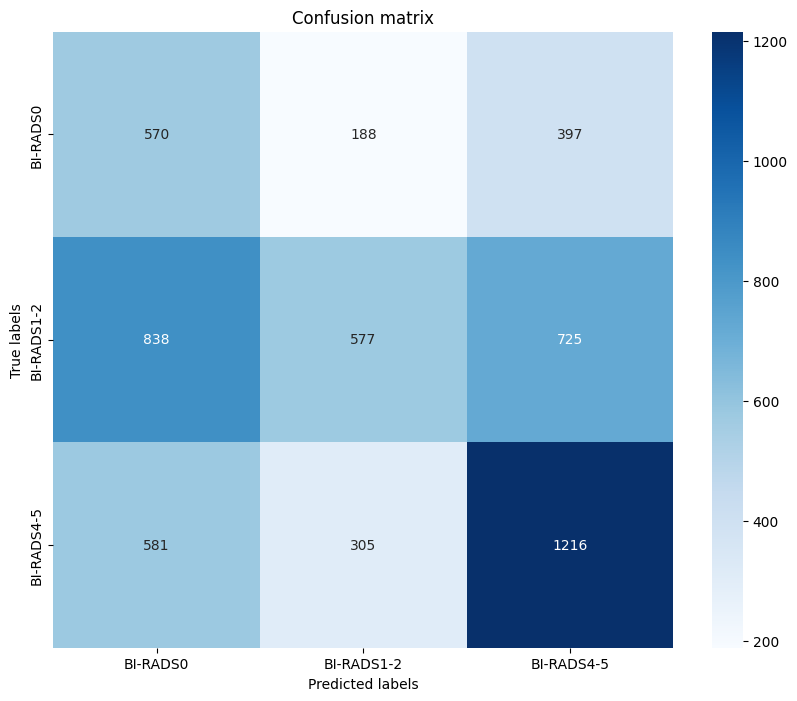


Epoch 2/20
----------


100%|██████████| 7311/7311 [22:32<00:00,  5.41it/s]


train Loss: 1.1068 Acc: 0.4141


100%|██████████| 2698/2698 [02:24<00:00, 18.68it/s]


val Loss: 1.0617 Acc: 0.4719


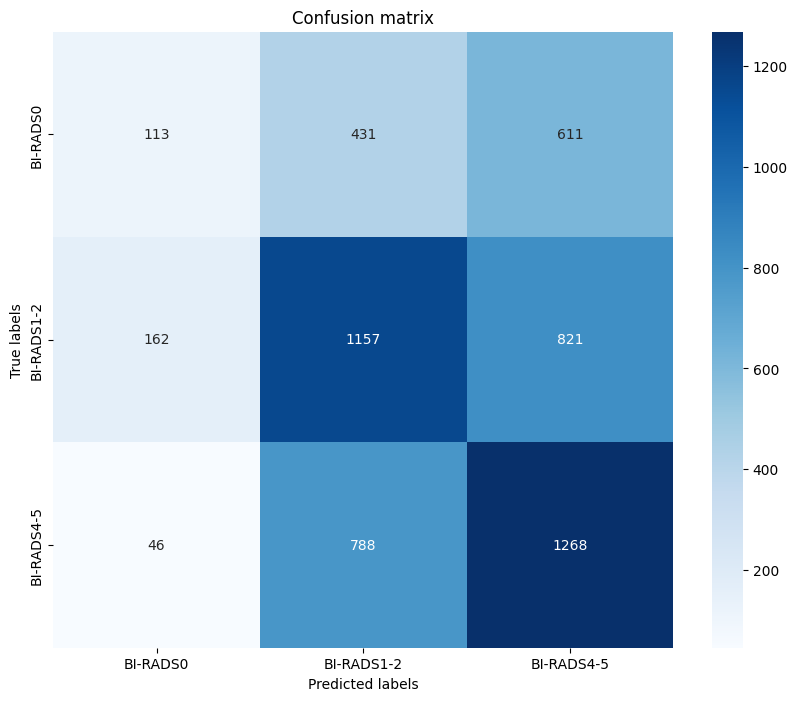


Epoch 3/20
----------


100%|██████████| 7311/7311 [22:19<00:00,  5.46it/s]


train Loss: 1.0940 Acc: 0.4249


100%|██████████| 2698/2698 [02:23<00:00, 18.78it/s]


val Loss: 1.1091 Acc: 0.4082

Epoch 4/20
----------


100%|██████████| 7311/7311 [22:14<00:00,  5.48it/s]


train Loss: 1.0862 Acc: 0.4310


100%|██████████| 2698/2698 [02:23<00:00, 18.77it/s]


val Loss: 1.0446 Acc: 0.4906


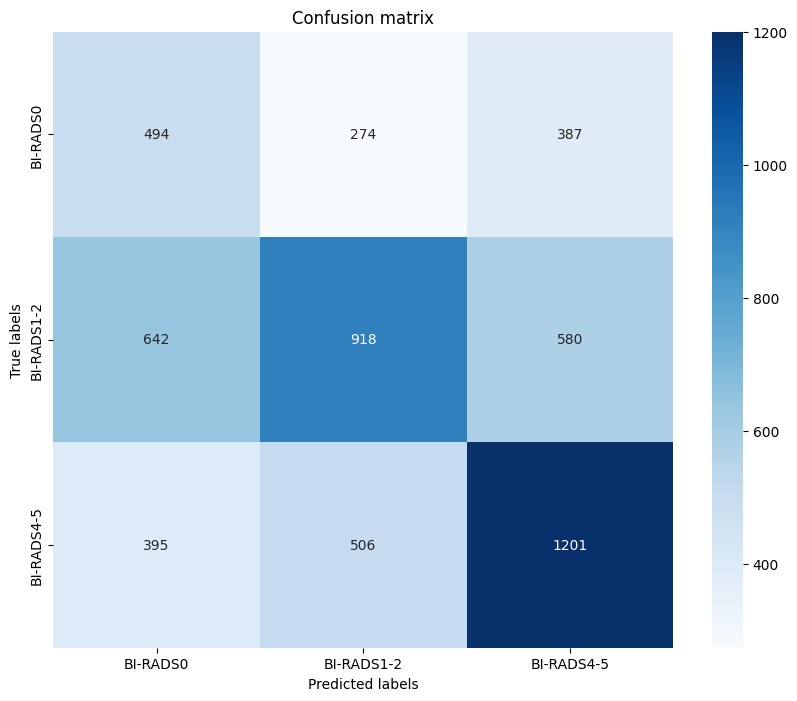


Epoch 5/20
----------


100%|██████████| 7311/7311 [22:15<00:00,  5.48it/s]


train Loss: 1.0678 Acc: 0.4474


100%|██████████| 2698/2698 [02:21<00:00, 19.03it/s]


val Loss: 1.0452 Acc: 0.4806

Epoch 6/20
----------


100%|██████████| 7311/7311 [22:08<00:00,  5.50it/s]


train Loss: 1.0819 Acc: 0.4402


100%|██████████| 2698/2698 [02:22<00:00, 18.97it/s]


val Loss: 1.0314 Acc: 0.4905

Epoch 7/20
----------


100%|██████████| 7311/7311 [22:14<00:00,  5.48it/s]


train Loss: 1.0788 Acc: 0.4407


 62%|██████▏   | 1670/2698 [01:27<00:53, 19.04it/s]


KeyboardInterrupt: 

In [19]:
for name,model in modeller.items(): 
    model_ft = model
    #model_ft=torch.load('C:/Users/Zeynep Aygün/Desktop/TEKNOFEST/yen/modelPerformance/vit/best_model_0.7244acc_20epochs.h5')
    
    """
    num_ftrs = model_ft.fc.in_features
    model_ft.fc =nn.Sequential(nn.Linear(num_ftrs, len(class_names)), nn.Softmax())"""

    """ num_ftrs=model.heads[-1].in_features
    model_ft.heads[-1]=nn.Sequential(nn.Linear(num_ftrs, len(class_names)), nn.Softmax())"""
    
    num_ftrs=model_ft.classifier.in_features
    model_ft.classifier =nn.Sequential(nn.Linear(num_ftrs, len(class_names)), nn.Softmax())
    
    model_ft = model_ft.to(device)

    criterion = nn.CrossEntropyLoss()

    # Observe that all parameters are being optimized
    optimizer_ft = optim.SGD(model_ft.parameters(), lr=LEARNING_RATE, momentum=0.9)
    #optimizer_ft = optim.Adam(model_ft.parameters(), lr=LEARNING_RATE)

    # Decay LR by a factor of 0.1 every 7 epochs
    exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=5, gamma=0.0001)

    # TRAINING
    model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, name=name,
                            num_epochs=EPOCH)

Dosya var
Epoch 1/20
----------


100%|██████████| 7311/7311 [36:49<00:00,  3.31it/s]  


train Loss: 1.0724 Acc: 0.4443


100%|██████████| 2698/2698 [02:43<00:00, 16.46it/s]


val Loss: 1.0427 Acc: 0.4825


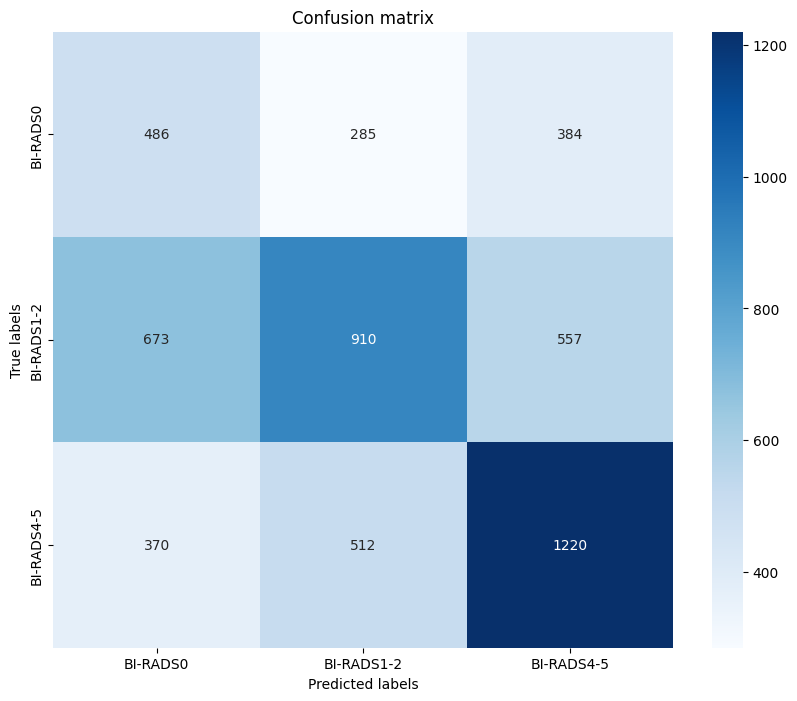


Epoch 2/20
----------


100%|██████████| 7311/7311 [22:30<00:00,  5.41it/s]


train Loss: 1.0610 Acc: 0.4598


100%|██████████| 2698/2698 [02:40<00:00, 16.77it/s]


val Loss: 1.0365 Acc: 0.4910


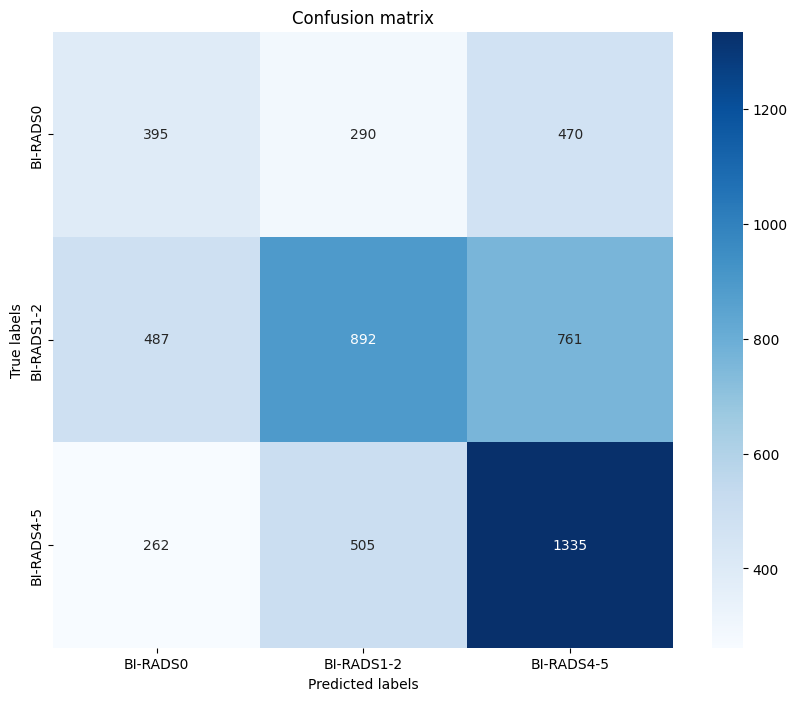


Epoch 3/20
----------


100%|██████████| 7311/7311 [22:18<00:00,  5.46it/s]


train Loss: 1.0608 Acc: 0.4550


100%|██████████| 2698/2698 [02:30<00:00, 17.93it/s]


val Loss: 1.0552 Acc: 0.4751

Epoch 4/20
----------


100%|██████████| 7311/7311 [22:19<00:00,  5.46it/s]


train Loss: 1.0446 Acc: 0.4747


100%|██████████| 2698/2698 [02:29<00:00, 18.09it/s]


val Loss: 1.0067 Acc: 0.5212


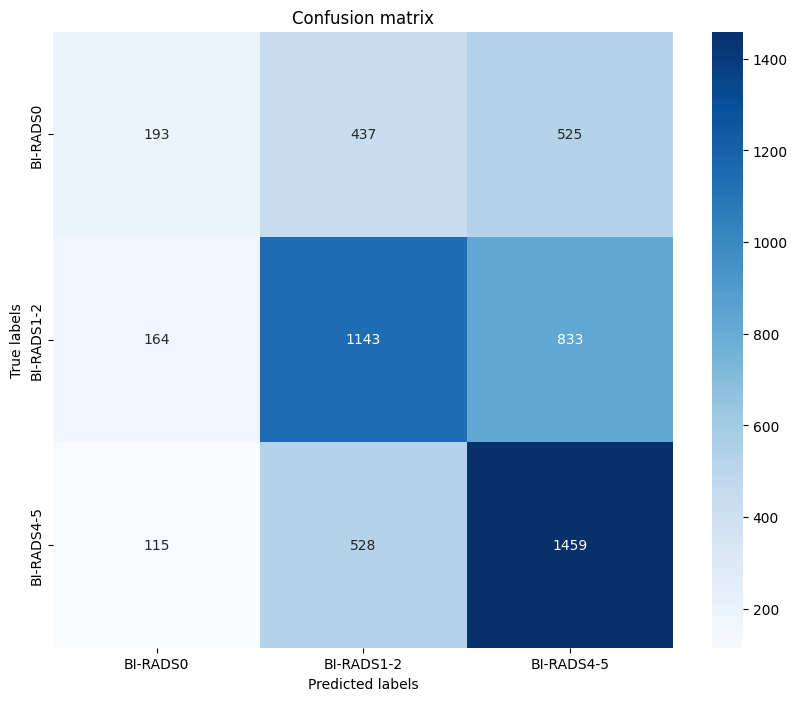


Epoch 5/20
----------


100%|██████████| 7311/7311 [22:11<00:00,  5.49it/s]


train Loss: 1.0479 Acc: 0.4719


100%|██████████| 2698/2698 [02:22<00:00, 18.93it/s]


val Loss: 1.0119 Acc: 0.5197

Epoch 6/20
----------


100%|██████████| 7311/7311 [22:23<00:00,  5.44it/s]


train Loss: 1.0239 Acc: 0.5011


100%|██████████| 2698/2698 [02:21<00:00, 19.08it/s]


val Loss: 1.0108 Acc: 0.5184

Epoch 7/20
----------


100%|██████████| 7311/7311 [22:10<00:00,  5.49it/s]


train Loss: 1.0351 Acc: 0.4862


100%|██████████| 2698/2698 [02:22<00:00, 18.96it/s]


val Loss: 1.0077 Acc: 0.5279


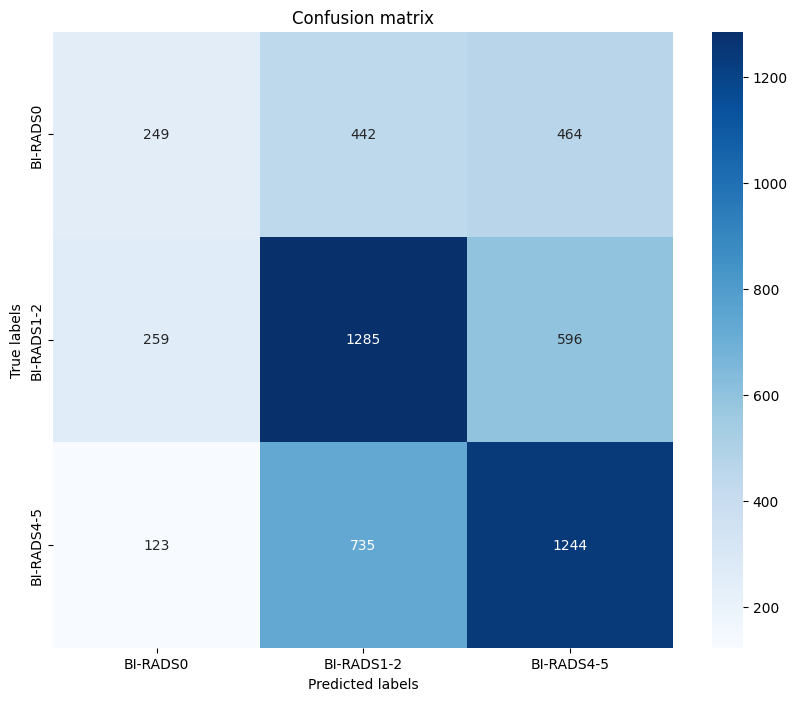


Epoch 8/20
----------


100%|██████████| 7311/7311 [22:15<00:00,  5.47it/s]


train Loss: 1.0314 Acc: 0.4939


100%|██████████| 2698/2698 [02:29<00:00, 18.03it/s]


val Loss: 1.0227 Acc: 0.5088

Epoch 9/20
----------


100%|██████████| 7311/7311 [22:16<00:00,  5.47it/s]


train Loss: 1.0252 Acc: 0.4996


100%|██████████| 2698/2698 [02:27<00:00, 18.23it/s]


val Loss: 1.0155 Acc: 0.5234

Epoch 10/20
----------


100%|██████████| 7311/7311 [22:18<00:00,  5.46it/s]


train Loss: 1.0229 Acc: 0.5009


100%|██████████| 2698/2698 [02:22<00:00, 18.93it/s]


val Loss: 1.0204 Acc: 0.5081

Epoch 11/20
----------


100%|██████████| 7311/7311 [22:08<00:00,  5.51it/s]


train Loss: 1.0351 Acc: 0.4876


100%|██████████| 2698/2698 [02:28<00:00, 18.13it/s]


val Loss: 1.0149 Acc: 0.5177

Epoch 12/20
----------


100%|██████████| 7311/7311 [22:18<00:00,  5.46it/s]


train Loss: 1.0338 Acc: 0.4925


100%|██████████| 2698/2698 [02:29<00:00, 17.99it/s]


val Loss: 1.0080 Acc: 0.5296


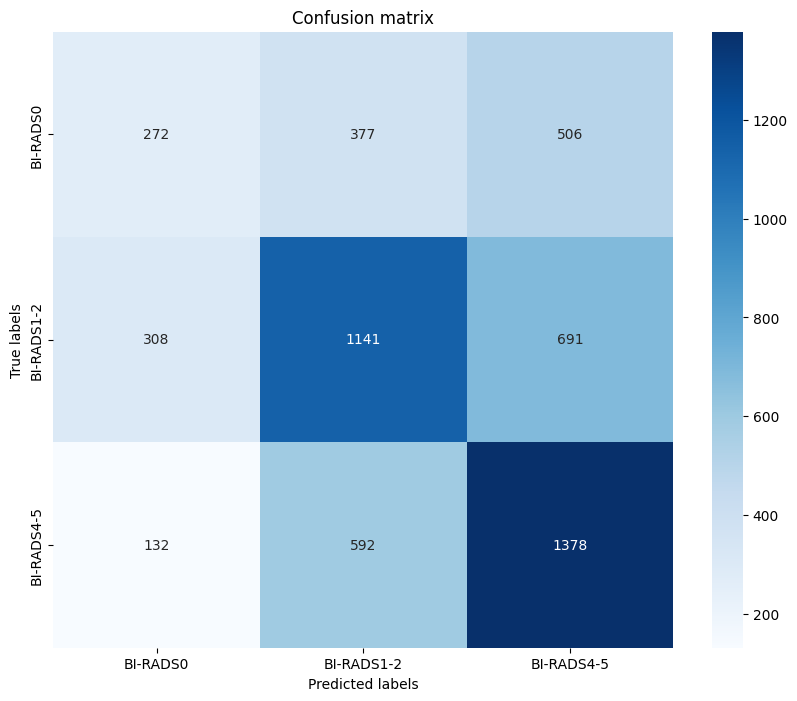


Epoch 13/20
----------


100%|██████████| 7311/7311 [22:09<00:00,  5.50it/s]


train Loss: 1.0251 Acc: 0.4985


100%|██████████| 2698/2698 [02:26<00:00, 18.47it/s]


val Loss: 1.0082 Acc: 0.5257

Epoch 14/20
----------


100%|██████████| 7311/7311 [22:22<00:00,  5.44it/s]


train Loss: 1.0258 Acc: 0.5006


100%|██████████| 2698/2698 [02:33<00:00, 17.62it/s]


val Loss: 1.0182 Acc: 0.5127

Epoch 15/20
----------


100%|██████████| 7311/7311 [22:19<00:00,  5.46it/s]


train Loss: 1.0231 Acc: 0.5015


100%|██████████| 2698/2698 [02:32<00:00, 17.70it/s]


val Loss: 1.0183 Acc: 0.5120

Epoch 16/20
----------


100%|██████████| 7311/7311 [22:18<00:00,  5.46it/s]


train Loss: 1.0293 Acc: 0.4935


100%|██████████| 2698/2698 [02:31<00:00, 17.85it/s]


val Loss: 1.0101 Acc: 0.5260

Epoch 17/20
----------


100%|██████████| 7311/7311 [22:18<00:00,  5.46it/s]


train Loss: 1.0295 Acc: 0.4929


100%|██████████| 2698/2698 [02:22<00:00, 18.94it/s]


val Loss: 1.0177 Acc: 0.5158

Epoch 18/20
----------


100%|██████████| 7311/7311 [22:25<00:00,  5.43it/s]


train Loss: 1.0247 Acc: 0.5002


100%|██████████| 2698/2698 [02:24<00:00, 18.70it/s]


val Loss: 1.0248 Acc: 0.5079

Epoch 19/20
----------


100%|██████████| 7311/7311 [22:22<00:00,  5.45it/s]


train Loss: 1.0239 Acc: 0.5006


100%|██████████| 2698/2698 [02:27<00:00, 18.25it/s]


val Loss: 1.0164 Acc: 0.5179

Epoch 20/20
----------


100%|██████████| 7311/7311 [22:19<00:00,  5.46it/s]


train Loss: 1.0317 Acc: 0.4913


100%|██████████| 2698/2698 [02:27<00:00, 18.31it/s]


val Loss: 1.0206 Acc: 0.5134

Training complete in 522m 50s
Best val Acc: 0.529553


In [9]:
for name,model in modeller.items(): 
    model_ft = model
    model_ft=torch.load('C:/Users/Zeynep Aygün/Desktop/teknofest_github/Mergen1-Teknofest/zeynep/modelPerformance/densenet169/best_model_0.4906acc_20epochs.h5')
    
    """
    num_ftrs = model_ft.fc.in_features
    model_ft.fc =nn.Sequential(nn.Linear(num_ftrs, len(class_names)), nn.Softmax())"""

    """ num_ftrs=model.heads[-1].in_features
    model_ft.heads[-1]=nn.Sequential(nn.Linear(num_ftrs, len(class_names)), nn.Softmax())"""
    
    """num_ftrs=model_ft.classifier.in_features
    model_ft.classifier =nn.Sequential(nn.Linear(num_ftrs, len(class_names)), nn.Softmax())"""
    
    model_ft = model_ft.to(device)

    criterion = nn.CrossEntropyLoss()

    # Observe that all parameters are being optimized
    optimizer_ft = optim.SGD(model_ft.parameters(), lr=LEARNING_RATE, momentum=0.9)
    #optimizer_ft = optim.Adam(model_ft.parameters(), lr=LEARNING_RATE)

    # Decay LR by a factor of 0.1 every 7 epochs
    exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=5, gamma=0.0001)

    # TRAINING
    model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, name=name,
                            num_epochs=EPOCH)

In [10]:
import torch
import matplotlib
import numpy as np
import seaborn as sns
from itertools import cycle
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import classification_report

class get_metric():

    def get_accuracy_graph(epochs, train_acc, val_acc):  # draw validation and train accuracy graphs
        plt.plot(epochs, train_acc, color='#006BA4')
        plt.plot(epochs, val_acc, color='#FF800E')
        plt.grid(b=True, which='major', color='lightgray')
        plt.grid(b=True, which='minor', color='lightgray')
        plt.xticks(np.arange(0, 45, 5))
        plt.yticks(np.arange(0.5, 1, 0.05))
        plt.rcParams['figure.figsize'] = (8, 6)
        plt.rcParams['figure.dpi'] = 600
        plt.xlabel("Number of Epochs")
        plt.ylabel("Accuracy")
        plt.title("Training Accuracy vs Validation Accuracy")
        plt.legend(['Training Acc.', 'Validation Acc.'], loc='lower right')
        plt.show()

    def get_loss_graph(epochs, train_losses, val_losses):  # draw validation and train loss graphs
        matplotlib.rcdefaults()
        plt.plot(epochs, train_losses, color='#006BA4')
        plt.plot(epochs, val_losses, color='#FF800E')
        plt.grid(b=True, which='major', color='lightgray')
        plt.grid(b=True, which='minor', color='lightgray')
        plt.xticks(np.arange(0, 45, 5))
        plt.yticks(np.arange(0, 1.2, 0.2))
        plt.rcParams['figure.dpi'] = 600
        plt.xlabel("Number of Epochs")
        plt.ylabel("Loss")
        plt.title("Training Loss vs Validation Loss")
        plt.legend(['Training Loss', 'Validation Loss'], loc='lower right')
        plt.show()

    def test_label_predictions(model, device, test_loader):  # calculate outputs on test dataset for get metrics
        model.eval()
        actuals = []
        predictions = []
        with torch.no_grad():
            for data, target in test_loader:
                data, target = data.to(device), target.to(device)
                model.to(device)
                output = model(data)
                prediction = output.argmax(dim=1, keepdim=True)
                actuals.extend(target.view_as(prediction))
                predictions.extend(prediction)
        return [i.item() for i in actuals], [i.item() for i in predictions]
    
    def test_label_predictions_el2(model_0,model_1,model_2,model_3, device, test_loader):
    
        actuals = []
        predictions = []

        with torch.no_grad():

            for data, target in test_loader:
                data, target = data.to(device), target.to(device)

                outputs_0 = model_0(data).cuda().cpu()
                _, predicted_0 =torch.max(outputs_0.data, 1) 

                outputs_1 = model_1(data)
                _, predicted_1 =torch.max(outputs_1.data, 1) 

                outputs_2 = model_2(data)
                _, predicted_2 =torch.max(outputs_2.data, 1)

                outputs_3 = model_3(data)
                _, predicted_3 =torch.max(outputs_3.data, 1)

                final_pred=predicted_1
                size=final_pred.size()

                for i in range(0,(size[0])):   
                    a=0              
                    if predicted_2[i].item()==0 and predicted_3[i].item()==0:

                        if predicted_1[i].item()==1:
                            final_pred[i]=1

                        if predicted_1[i].item()==0:
                            final_pred[i]=0
                        a+=1

                    if (predicted_0[i].item()==1 and predicted_1[i].item()==1) :

                        a+=1   
                        if predicted_3[i].item()==0:
                            final_pred[i]=0 

                        if predicted_3[i].item()!=0:
                            final_pred[i]=1                    
                    if a==0:                   
                        final_pred[i]=predicted_2[i] 
                actuals.extend(target.view_as(final_pred))
                predictions.extend(final_pred)
        return [i.item() for i in actuals], [i.item() for i in predictions]

    def test_model(model ,device, test_loader):
        correct = 0
        total = 0
        with torch.no_grad():
            for data in test_loader:
                images, labels = data[0].to(device), data[1].to(device)
                outputs = model(images)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        print('Correct Prediction: {:d}  Total Images: {:d}'.format(correct, total))
        print('Test Accuracy = {:f}'.format(correct / total))
    
    def test_model_el2(model_0,model_1,model_2,model_3,device, test_loader):
        
        correct = 0
        total = 0

        with torch.no_grad():
            for data in test_loader:

                images, labels = data[0].to(device), data[1].to(device)

                outputs_0 = model_0(images)
                _, predicted_0 =torch.max(outputs_0.data, 1) 

                outputs_1 = model_1(images)
                _, predicted_1 =torch.max(outputs_1.data, 1) 

                outputs_2 = model_2(images)
                _, predicted_2 =torch.max(outputs_2.data, 1)

                outputs_3 = model_3(images)
                _, predicted_3 =torch.max(outputs_3.data, 1)

                final_pred=predicted_1
                size=final_pred.size()

                for i in range(0,(size[0])):   
                    a=0              
                    if predicted_2[i].item()==0 and predicted_3[i].item()==0:

                        if predicted_1[i].item()==1:
                            final_pred[i]=1

                        if predicted_1[i].item()==0:
                            final_pred[i]=0
                        a+=1

                    if (predicted_0[i].item()==1 and predicted_1[i].item()==1):

                        a+=1

                        if predicted_3[i].item()==0:
                            final_pred[i]=0                        
                        if predicted_3[i].item()!=0:
                            final_pred[i]=1
                    if a==0:                   
                        final_pred[i]=predicted_2[i]

                total += labels.size(0)
                correct += (final_pred == labels).sum().item()
        print('Correct Prediction: {:d}  Total Images: {:d}'.format(correct, total))
        print('Test Accuracy = {:f}'.format(correct / total))

    def get_classification_report(truth, predict):  # create classification report for each class with scikit-learn library
        print('Classification Report :\n', classification_report(truth, predict))

    def get_confusion_matrix(actuals, predictions):  # create confusion matrix for each class with scikit-learn library
        matplotlib.rcdefaults()
        print('Confusion matrix:\n',confusion_matrix(actuals, predictions))
        cf_matrix=confusion_matrix(actuals, predictions)
        sns.heatmap(cf_matrix, annot=True,fmt='g', cmap='Blues')

    def get_cohen_kappa(actuals, predictions):  # get cohen kapa score for   determine model performance
        cps = cohen_kappa_score(actuals, predictions)
        print('Kappa Score of this model:\n', cps)

    def test_class_probabilities(model, device, test_loader, which_class):
        
        truths = []
        probabilities = []
        with torch.no_grad():
            for data, target in test_loader:
                data, target = data.to(device), target.to(device)
                output = model(data).cuda().cpu()
                prediction = output.argmax(dim=1, keepdim=True)
                truths.extend(target.view_as(prediction) == which_class)
                probabilities.extend(np.exp(output[:, which_class]))
        return [i.item() for i in truths], [i.item() for i in probabilities]
    def test_class_probabilities_el2(model_0,model_1,model_2,model_3, device, test_loader, which_class):
    
        truths = []
        probabilities = []

        with torch.no_grad():
            for data, target in test_loader:

                data, target = data.to(device), target.to(device)

                outputs_0 = model_0(data)
                _, predicted_0 =torch.max(outputs_0.data, 1) 

                outputs_1 = model_1(data)
                _, predicted_1 =torch.max(outputs_1.data, 1) 

                outputs_2 = model_2(data)
                _, predicted_2 =torch.max(outputs_2.data, 1)

                outputs_3 = model_3(data)
                _, predicted_3 =torch.max(outputs_3.data, 1)

                final_pred=predicted_1
                out=outputs_1
                size=final_pred.size()

                for i in range(0,(size[0])):   
                    a=0              
                    if predicted_2[i].item()==0 and predicted_3[i].item()==0:

                        if predicted_1[i].item()==1:
                            #final_pred[i]=1
                            out[i]=outputs_1[i]

                        if predicted_1[i].item()==0:
                            final_pred[i]=0
                            out[i]=outputs_1[i]
                        a+=1

                    if (predicted_0[i].item()==1 and predicted_1[i].item()==1):

                        a+=1

                        if predicted_3[i].item()==0:
                            #final_pred[i]=0
                            out[i]=outputs_3[i]

                        if predicted_3[i].item()!=0:
                            #final_pred[i]=1
                            out[i]=outputs_3[i]
                    if a==0:                   
                        #final_pred[i]=predicted_2[i]
                        out[i]=outputs_2[i]
                prediction = out.argmax(dim=1, keepdim=True)
                truths.extend(target.view_as(prediction) == which_class)
                probabilities.extend(np.exp(out.cuda().cpu()[:, which_class]))
        return [i.item() for i in truths], [i.item() for i in probabilities]
    
    def get_roc_curves_el2(model_0,model_1,model_2,model_3, device, data):  # draw Roc curves and calculate auc score for each class
        fpr = dict()
        tpr = dict()
        roc_auc = dict()

        actuals, class_probabilities = get_metric.test_class_probabilities_el2(model_0,model_1,model_2,model_3, device, data, 0)
        fpr[0], tpr[0], _ = roc_curve(actuals, class_probabilities)
        roc_auc[0] = roc_auc_score(actuals, class_probabilities)

        actuals, class_probabilities = get_metric.test_class_probabilities_el2(model_0,model_1,model_2,model_3, device, data, 1)
        fpr[1], tpr[1], _ = roc_curve(actuals, class_probabilities)
        roc_auc[1] = roc_auc_score(actuals, class_probabilities)

        print("Auc Score For Each Class: ", roc_auc)

        matplotlib.rcdefaults()
        plt.figure()
        colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
        for i, color in zip(range(2), colors):
            plt.plot(fpr[i], tpr[i], color=color, lw=1,
            label='ROC curve of class {0} (area = {1:0.4f})'
            ''.format(i, roc_auc[i]))
        plt.plot([0, 1], [0, 1], 'k--', lw=1)
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.legend(loc="lower right")
        plt.show()

    def get_roc_curves(model, device, data):  # draw Roc curves and calculate auc score for each class
        fpr = dict()
        tpr = dict()
        roc_auc = dict()

        actuals, class_probabilities = get_metric.test_class_probabilities(model, device, data, 0)
        fpr[0], tpr[0], _ = roc_curve(actuals, class_probabilities)
        roc_auc[0] = roc_auc_score(actuals, class_probabilities)

        actuals, class_probabilities = get_metric.test_class_probabilities(model, device, data, 1)
        fpr[1], tpr[1], _ = roc_curve(actuals, class_probabilities)
        roc_auc[1] = roc_auc_score(actuals, class_probabilities)

        actuals, class_probabilities = get_metric.test_class_probabilities(model, device, data, 2)
        fpr[2], tpr[2], _ = roc_curve(actuals, class_probabilities)
        roc_auc[2] = roc_auc_score(actuals, class_probabilities)

        actuals, class_probabilities = get_metric.test_class_probabilities(model, device, data, 3)
        fpr[3], tpr[3], _ = roc_curve(actuals, class_probabilities)
        roc_auc[3] = roc_auc_score(actuals, class_probabilities)

        print("Auc Score For Each Class: ", roc_auc)

        matplotlib.rcdefaults()
        plt.figure()
        colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
        for i, color in zip(range(2), colors):
            plt.plot(fpr[i], tpr[i], color=color, lw=1,
                label='ROC curve of class {0} (area = {1:0.4f})'
                    ''.format(i, roc_auc[i]))
        plt.plot([0, 1], [0, 1], 'k--', lw=1)
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.legend(loc="lower right")
        plt.show()



densenet169
-----------------
F1 Score: 0.2913765399035887 0.5369411764705883 0.5892666239042121
Recall: 0.2354978354978355 0.5331775700934579 0.6555661274976213 
Precision: 0.38202247191011235 0.5407582938388625 0.5351456310679612


Classification Report :
               precision    recall  f1-score   support

           0       0.38      0.24      0.29      1155
           1       0.54      0.53      0.54      2140
           2       0.54      0.66      0.59      2102

    accuracy                           0.52      5397
   macro avg       0.49      0.47      0.47      5397
weighted avg       0.50      0.52      0.50      5397

Correct Prediction: 2791  Total Images: 5397
Test Accuracy = 0.517139
Kappa Score of this model:
 0.2346721608662995


Confusion matrix:
 [[ 272  377  506]
 [ 308 1141  691]
 [ 132  592 1378]]




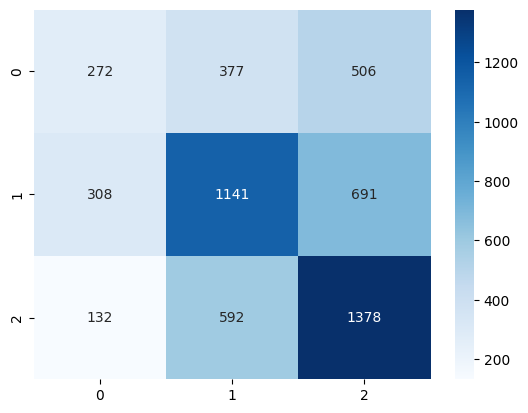

In [11]:
from sklearn.metrics import f1_score,accuracy_score,recall_score,roc_auc_score,roc_curve,confusion_matrix,precision_score,recall_score
print('\n'+'densenet169'+'\n-----------------')  
model_ft=torch.load('C:/Users/Zeynep Aygün/Desktop/teknofest_github/Mergen1-Teknofest/zeynep/modelPerformance/densenet169/best_model_0.5296acc_20epochs.h5')
phase='val'
actuals, predictions = get_metric.test_label_predictions(model_ft, device, dataloaders[phase])
f1=f1_score(predictions,actuals,average=None)
recall=recall_score(actuals,predictions,average=None)
precision=precision_score(actuals,predictions,average=None)
print(f'F1 Score: {f1[0]} {f1[1]} {f1[2]}')
print(f'Recall: {recall[0]} {recall[1]} {recall[2]} ')
print(f'Precision: {precision[0]} {precision[1]} {precision[2]}')
print('\n')
get_metric.get_classification_report(actuals, predictions)
get_metric.test_model(model_ft,device,dataloaders[phase])
get_metric.get_cohen_kappa(actuals, predictions)
print('\n')
get_metric.get_confusion_matrix(actuals, predictions)
print('\n')
#get_metric.get_roc_curves(model_ft, device,  dataloaders[phase])